# Análise de Risco de Crédito - NuBank

# Risco de Crédito e Prevenção de Inadimplência

O **risco de crédito** está associado à possibilidade de um cliente não cumprir com as obrigações contratuais, como hipotecas, dívidas de cartão de crédito e outros tipos de empréstimos. 

Minimizar o risco de inadimplência é uma grande preocupação para instituições financeiras. Por esse motivo, bancos comerciais e de investimento, fundos de capital de risco, empresas de gestão de ativos e seguradoras, entre outros, estão cada vez mais utilizando a tecnologia para prever quais clientes são mais propensos a não honrar suas dívidas.

## A Tecnologia no Gerenciamento de Risco

Modelos de **Machine Learning** têm ajudado essas empresas a melhorar a precisão de suas análises de risco de crédito, fornecendo um método científico para identificar devedores em potencial com antecedência.

## O Projeto: Previsão de Inadimplência para o Nubank

Neste projeto, construiremos um modelo para prever o risco de inadimplência de clientes para o **Nubank**, uma das maiores e mais importantes Fintechs brasileiras.

### Variável Dependente: Inadimplência

A inadimplência é a **variável dependente** neste caso, e seu evento pode ou não ocorrer, dependendo das variáveis explicativas inseridas nos modelos. Essas variáveis são **qualitativas dicotômicas**, representando cada um dos fenômenos em estudo. O objetivo é estimar a probabilidade de ocorrência desse fenômeno.

### Técnica Utilizada: Regressão Logística Binária

Para isso, faremos uso da **regressão logística binária**. O caso apresenta a inadimplência por meio de duas categorias:

- **`target_default` com valor `False`**: Representa o não evento de interesse (dummy = 0).
- **`target_default` com valor `True`**: Representa o evento de interesse (dummy = 1).

A primeira categoria será a de referência, e a segunda indicará o evento de inadimplência. A regressão logística binária será utilizada para estimar a probabilidade de ocorrência do evento de interesse.

## Modelagem 

## Objetivo

- **Prever o risco de inadimplência de clientes** utilizando modelos de aprendizado de máquina, incluindo:
  - Regressão Logística
  - XGBoost
  - LightGBM
  - CatBoost

- **Problema**: Identificar a possibilidade de clientes não cumprirem obrigações contratuais, como empréstimos e pagamentos.

### Importação das Bibliotecas

In [143]:
# Importações de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn para machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error, roc_auc_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, recall_score, auc
)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Outras bibliotecas
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.process import stepwise

# Configurações de warnings
import warnings
warnings.filterwarnings('ignore')

# Configurações do pandas
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', None)  # Mostra todas as linhas
pd.set_option('display.max_columns', None)  # Mostra todas as colunas (se necessário)

from exception import CustomException
import sys

# Funções


## Funcão para detectar Outliers e Remoção

- Função que detecta e substitui outliers por NaN com base no método IQR.

In [144]:
def detectar_e_substituir_outliers(df):

    for column in df.select_dtypes(include=[np.number]).columns:  # Process only numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with NaN
        df[column] = df[column].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)

    print("Os valores discrepantes foram substituídos por NaN.")
    return df

## Função da Matriz de Confusão

In [145]:
def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

## Função de avaliação para avaliar o desempenho de um modelo

In [146]:
# def evaluate_model(true, predicted):
#     mae = mean_absolute_error(true, predicted)
#     mse = mean_squared_error(true, predicted)
#     rmse = np.sqrt(mean_squared_error(true, predicted))
#     r2_square = r2_score(true, predicted)
#     return mae, rmse, r2_square

## Função 'espec_sens'

- Criação da função 'espec_sens' para a construção de um dataset com diferentes valores de cutoff, sensitividade e especificidade:

In [147]:
def espec_sens(observado,predicts):
    
    values = predicts.values
    
    cutoffs = np.arange(0,1.01,0.01)
    
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

## Função para mudar Boolean para Inteiro

In [148]:
def convert_boolean_to_int(df, column_name):
    if column_name in df.columns:
        df[column_name] = df[column_name].fillna(False).astype(int)
    else:
        raise ValueError(f"A coluna '{column_name}' não existe no Dataframe.")
    return df

## Função para substituir valores com 0 para Nan

In [149]:
def replace_zero_with_nan(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: np.nan if x == 0 else x)
    return df

## Função para mudar valores Inf e -Inf para Nan 

In [150]:
def replace_inf_with_nan(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

## Função para categorizar o score_3

In [151]:
def categorize_score(df, column="score_3"):
    df["score"] = ""
    df.loc[df[column] <= 300, "score"] = "baixo"
    df.loc[(df[column] >= 301) & (df[column] <= 700), "score"] = "medio"
    df.loc[df[column] >= 701, "score"] = "alto"
    
    return df

## Importação do Dataset

In [152]:
df = pd.read_csv('data/acquisition_train.csv')

## Visualização dos Dados

In [153]:
df.head(2).T

,0,1
ids,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,bc2c7502-bbad-0f8c-39c3-94e881967124
target_default,False,False
score_1,1Rk8w4Ucd5yR3KcqZzLdow==,DGCQep2AE5QRkNCshIAlFQ==
score_2,IOVu8au3ISbo6+zmfnYwMg==,SaamrHMo23l/3TwXOWgVzw==
score_3,350.00,370.00
score_4,101.80,97.06
score_5,0.26,0.94
score_6,108.43,92.00
risk_rate,0.40,0.24
last_amount_borrowed,"25,033.92",NaN


## Infos dos Dados

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

- Temos dados ausentes

## Exclusão das Variáveis não significativas

- Seguindo como base os processos feitos na Análise Exploratória de Dados - EDA, vamos excluir logo de início as variáveis não relevantes para o projeto, seguido da variável **Shipping State** por não agregar até o momento nenhuma significância para o projeto. Por enquanto não temos valor na distribuição dos estados com relação as outras variáveis.

In [155]:
# cópia do dataframe
df2 = df.copy()

In [156]:
exclude_columns = ["ids", "score_1", "score_2", "score_4", "score_5", "score_6","reason", "facebook_profile", "state", "zip", "channel", "job_name", "real_state",
                    "email", "external_data_provider_first_name", "external_data_provider_email_seen_before","lat_lon", "marketing_channel",
                    "application_time_applied", "profile_phone_number", "application_time_in_funnel","shipping_zip_code", "external_data_provider_fraud_score",
                    "profile_tags", "user_agent", "shipping_state","target_fraud"]

df2.drop(labels = exclude_columns, axis=1, inplace=True)

## Alteração variável Target Default para Num

- Neste código convertemos os valores **booleanos (True ou False)** da coluna target_default para valores numéricos (1 ou 0, respectivamente). Isso é comum em machine learning ou análise de dados, onde variáveis categóricas ou booleanas precisam ser transformadas em números para serem processadas por algoritmos.

In [157]:
df2 = convert_boolean_to_int(df2, "target_default")

## Alteração da Variável credit_limit com valor 0

- A variável **credit_limit** possui um valor mínimo de 0.000000, isso não existe em instituições financeiras, é obrigatório liberar um valor X de crédito para o cliente. Portanto, este valor será substituído por NaN.

In [158]:
df2 = replace_zero_with_nan(df2, "credit_limit")

## Alteração da Variável reported_income com Valor Inf

- A variável **reported_income** possui um valor máximo descrito como inf(infinito), nesse caso, vamos alterar para o tipo NaN.

In [159]:
df2 = replace_inf_with_nan(df2)

## Feature Engineering

## Criação da Variável `Scores`

Seguindo o que foi feito com as **"Perguntas de Negócio utilizando o Score 3"** na **Análise Exploratória** do arquivo `eda.ipynb`, que é o score mais robusto para o projeto, vamos criar uma nova variável chamada **`Scores`**. Essa variável será dividida com base na descrição do score anteriormente mencionada.

## Divisão do Score Brasileiro

O score brasileiro é geralmente dividido em faixas:

- **Baixo (0-300):** Alto risco de inadimplência.
- **Médio (301-700):** Risco moderado.
- **Alto (701-1000):** Baixo risco de inadimplência.

## Implementação

Com base nessa divisão, criaremos uma variável chamada **`score`**, que será categorizada de acordo com as faixas acima. Além disso, para essa nova análise, **excluiremos as outras colunas de score** existentes.

In [160]:
df2 = categorize_score(df2)

- Exclusão da variável score_3

In [161]:
df2.drop(columns=['score_3'], axis = 1, inplace = True)	

## Modelos Logísticos Binários

## Respostas Binárias e Regressão Logística

Respostas binárias são comumente estudadas em diversos campos. Exemplos incluem:

- Presença ou ausência de uma doença específica.
- Morte durante uma cirurgia.
- Decisão de um consumidor em comprar um produto.

Frequentemente, o objetivo é estudar como um conjunto de **variáveis preditoras** (**X**) está relacionado a uma **variável de resposta dicotômica** (**Y**). Esses preditores podem incluir:

- Atribuição de tratamento.
- Dosagem.
- Fatores de risco.
- Tempo de calendário.

## Definição da Resposta Binária

Por conveniência, definimos a resposta como **Y = 0** ou **Y = 1**, onde:

- **Y = 1** denota a ocorrência do evento de interesse.
- **Y = 0** denota a não ocorrência.

Em muitos casos, um resultado dicotômico pode ser estudado calculando proporções, como:

- Proporção de mortes entre mulheres.
- Proporção de mortes entre homens.

No entanto, quando há múltiplos descritores ou quando um ou mais descritores são contínuos, a análise se torna mais complexa. Sem um modelo estatístico, seria necessário criar grupos arbitrários (por exemplo, faixas etárias) para estimar a prevalência de uma doença em função da idade.

## Regressão Logística vs. Regressão Linear

Diferentemente da **regressão linear tradicional**, que é estimada por métodos de **mínimos quadrados** e aplicada a variáveis dependentes quantitativas, a **regressão logística** é utilizada quando a variável dependente é qualitativa. Nesses casos, a variável dependente é representada por uma ou mais variáveis **dummy**, dependendo do número de categorias possíveis.

### Características da Regressão Logística

- **Variável dependente**: Binária (0 ou 1).
- **Variáveis preditoras**: Podem ser métricas (contínuas) ou não métricas (categóricas).
- **Interpretação**: Os resultados são expressos em termos de probabilidades.

## Aplicação em Machine Learning

Em **Machine Learning**, a regressão logística é uma técnica **supervisionada** usada para:

1. **Explicar** a probabilidade de ocorrência de um evento.
2. **Prever** a ocorrência de um evento com base em uma ou mais variáveis explicativas.

Essa técnica é especialmente útil quando a variável dependente é binária, e os resultados são interpretados como probabilidades.

## O Modelo de Regressão Logística Binária

O modelo de regressão logística binária é uma técnica estatística usada para prever a probabilidade de ocorrência de um evento que tem dois resultados possíveis (binário). Ele é amplamente utilizado em problemas de classificação, onde a variável dependente (resposta) é categórica e assume apenas dois valores, como 0 ou 1, "Sim" ou "Não", "Sucesso" ou "Fracasso".

## Conceito Básico

A regressão logística modela a probabilidade de um evento ocorrer usando uma função logística (também chamada de sigmoide). A função **sigmoide** transforma qualquer valor real em um valor entre 0 e 1, que pode ser interpretado como uma probabilidade.

## Função Sigmoide

A função sigmoide é dada por:

$$P(Y = 1 \mid X) = \frac{1}{1 + e^{-\left(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n\right)}}$$

Onde: 

- $P(Y = 1 \mid X)$ é a probabilidade de a variável dependente **Y** ser igual a 1, dado o conjunto de variáveis independentes **X**.

- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ são os coeficientes do modelo.

- $X_1, X_2, \dots, X_n$ são as variáveis independentes (ou características).

- $e$ é a base do logaritmo natural (aproximadamente 2.71828).





## Função de Ligação (Logit)

A regressão logística usa a função de ligação logit para modelar a relação entre as variáveis independentes e a probabilidade de ocorrência do evento. O logit é o logaritmo natural da razão de chances (odds ratio):

$$\text{logit}(P(Y = 1 \mid X)) = \ln\left(\frac{1 - P(Y = 1 \mid X)}{P(Y = 1 \mid X)}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n$$


## Estimação dos Coeficientes

Os coeficientes $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ são estimados usando o método de máxima verossimilhança (Maximum Likelihood Estimation - MLE). O objetivo é encontrar os valores dos coeficientes que maximizam a função de verossimilhança, que é a probabilidade de observar os dados dados os parâmetros do modelo.

## Interpretação dos Coeficientes

- Coeficiente $\beta_0$: É o intercepto do modelo. Representa o logaritmo da razão de chances quando todas as variáveis independentes são iguais a zero.

- Coeficientes $\beta_1, \beta_2, \dots, \beta_n$: Representam a mudança no logaritmo da razão de chances para um aumento unitário na variável independente correspondente, mantendo todas as outras variáveis constantes.

## Odds

Na regressão logística, o conceito de chance (ou odds, em inglês) é fundamental para entender como o modelo estima a probabilidade de um evento ocorrer. Vamos explorar o que significa "chance" e como ela se relaciona com a regressão logística.

1. O que é Chance?

A chance é uma medida que compara a probabilidade de um evento ocorrer com a probabilidade de ele não ocorrer. Em outras palavras, é a razão entre a probabilidade de sucesso $\left(P(Y = 1)\right)$ e a probabilidade de fracasso $\left(P(Y = 0)\right)$
.

A fórmula da chance é: 

$$\text{Chance} = \frac{P(Y = 1)}{1 - P(Y = 1)}$$

Onde: 

- ${P(Y = 1)}$ é a probabilidade de o evento ocorrer.
- ${1 - P(Y = 1)}$ é a probabilidade de o evento não ocorrer.



2. Exemplo de Chance

Suponha que a probabilidade de um evento ocorrer seja $(P(Y = 1) = 0.75$. Então:

- A probabilidade de o evento não ocorrer é $1 - 0,75 = 0,25$.
- A chance de o evento ocorrer é: $$\text{Chance} = \frac{0,75}{0,25} = 3$$

Isso significa que a chance de o evento ocorrer é **3 para 1** (ou seja, o evento é 3 vezes mais provável de ocorrer do que não ocorrer).

3. Chance e Regressão Logística

Na regressão logística, o modelo estima a chance de um evento ocorrer com base nas variáveis independentes $(X)$. A relação entre as variáveis independentes e a chance é modelada pela função logística.

A regressão logística usa o **logaritmo da chance** (também chamado de logit) como variável dependente. A fórmula do logit é:

$$\text{logit}(P(Y = 1)) = \ln\left(\frac{P(Y = 1)}{1 - P(Y = 1)}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n$$

Onde:

- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ são os coeficientes do modelo.
- $X_1, X_2, \dots, X_n$ são as variáveis independentes (ou características).


In [162]:
df2.head()

,target_default,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,reported_income,score
0,0,0.40,"25,033.92",36.00,NaN,"65,014.12",NaN,0.00,0.00,18.00,18.00,NaN,2,0.00,"57,849.00",medio
1,0,0.24,NaN,NaN,"39,726.00","100,018.91",50.00,0.00,0.00,14.00,14.00,0.00,1,0.00,"4,902.00",medio
2,1,0.29,"7,207.92",36.00,NaN,"65,023.65",NaN,0.00,0.00,10.00,NaN,NaN,2,NaN,"163,679.00",medio
3,0,0.32,NaN,NaN,"54,591.00","68,830.01",NaN,1.00,0.00,19.00,19.00,NaN,3,NaN,"1,086.00",medio
4,0,0.18,NaN,NaN,NaN,"60,011.29",NaN,0.00,0.00,11.00,NaN,0.00,2,1.00,"198,618.00",medio


In [163]:
df2.columns

Index(['target_default', 'risk_rate', 'last_amount_borrowed',
       'last_borrowed_in_months', 'credit_limit', 'income', 'ok_since',
       'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues',
       'external_data_provider_credit_checks_last_2_year',
       'external_data_provider_credit_checks_last_month',
       'external_data_provider_credit_checks_last_year', 'reported_income',
       'score'],
      dtype='object')

## Divisão dos dados em treino e teste

- Antes de iniciar as transformações e pré-processamentos dos dados, é necessário dividir o dataset em treino e teste, mas porque?
    - Porque precisamos evitar o "Data Leakage". Data Leakage ocorre quando informações do conjunto de dados de teste ou validação vazam para o conjunto de treinamento durante o pré-processamento ou modelagem, ou quando informaçõpes do target vazam para as features. Nessas situações, o que vai acontecer é que você vai ver um modelo muito bom, mas isso será ilusório, pois o seu modelo "roubou" para ter o resultado bom.

- Referências sobre Data Leakage: 
    - https://www.linkedin.com/company/universidade-dos-dados/posts/?feedView=all
    - https://www.casadocodigo.com.br/products/livro-escd
    - https://estatsite.com.br/2020/12/12/data-leakage-o-erro-que-ate-os-grandes-cometem/


In [164]:
# Dividindo os dados primeiro

X = df2.drop(columns=['target_default'], axis = 1)	
y = df2['target_default'].copy()                                                                                                                                                                                                                                                                                    

## Aplicando o One Hot Encoding antes do Train Test Split

In [165]:
# Aplicando o One Hot Encoding

encoder = OneHotEncoder(drop='first', sparse_output=False) 

X_encoded = encoder.fit_transform(X[['score']])

encoded_columns = encoder.get_feature_names_out(['score'])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns, index=X.index)

X = pd.concat([X.drop(columns=['score']), X_encoded_df], axis=1)

## Remoção dos Outliers

- Aqui vamos remover os Outliers para um primeiro CRISP-DM, então o dataset não terá os valores discrepantes para criação dos modelos. 

In [166]:
X = detectar_e_substituir_outliers(X)

Os valores discrepantes foram substituídos por NaN.


## Boxplot Dataframe Atualizado

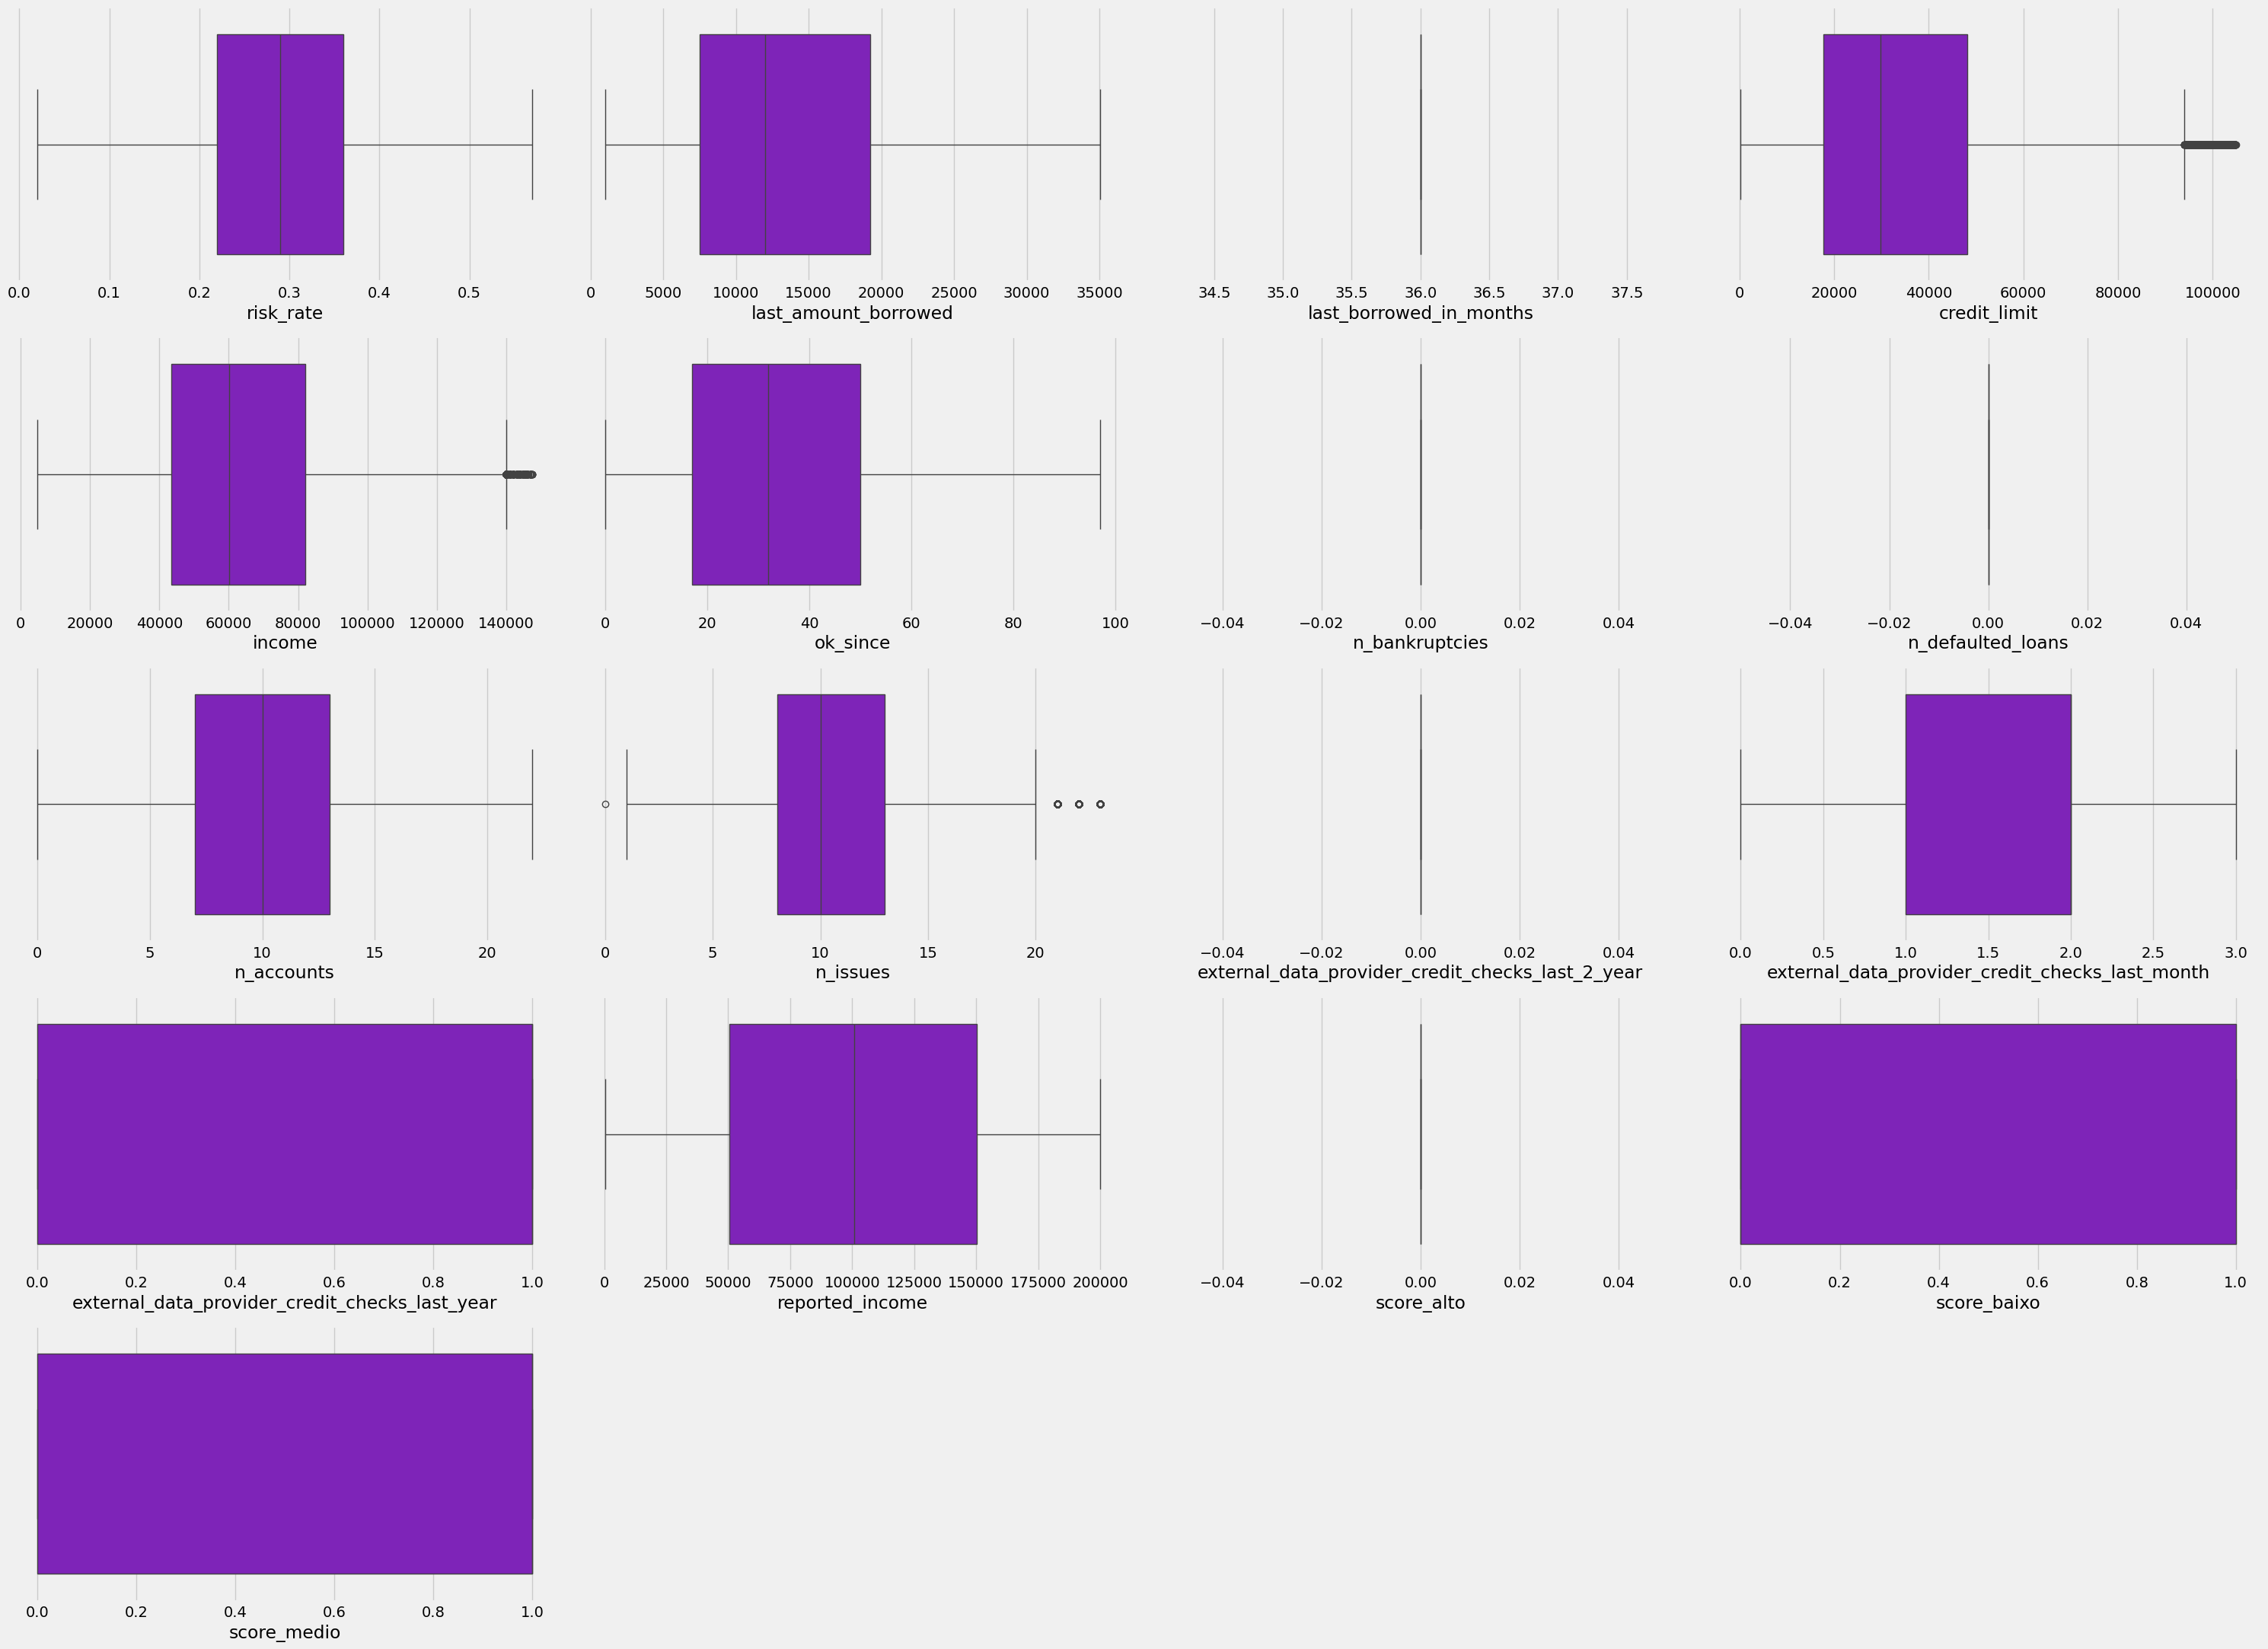

In [167]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,30))
for index,column in enumerate(X):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=X,x=column, color="#830BD1")
    
plt.tight_layout(pad = 1.0)

## Train Test Split

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## Pré-Processamento

- Preencher valores ausentes em X_train e X_test

In [169]:
# Preencher valores ausentes em X_train e X_test com a média de X_train
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)  # Usar a média de X_train para X_test

- Preencher valores ausentes em y_train e y_test

In [170]:
# Preencher valores ausentes em y_train e y_test com a mediana
y_train.fillna(y_train.median(), inplace=True)
y_test.fillna(y_train.median(), inplace=True)  # Usar a mediana de y_train para y_test


- Divisão das variáveis numéricas e categóricas

In [171]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
categorical_features = X_train.select_dtypes('object').columns.to_list()

- Número de linhas e colunas de cada treino e teste criados

In [172]:
print(f'Train shape: {X_train.shape}.')
print(f'Train target shape: {y_train.shape}.')
print(f'Test predictor shape: {X_test.shape}.')
print(f'Test target shape: {y_test.shape}.')

Train shape: (36000, 17).
Train target shape: (36000,).
Test predictor shape: (9000, 17).
Test target shape: (9000,).


## Estimação do Modelo Logístico Binário pela função "smf.glm"

A função **smf.glm** faz parte da biblioteca **statsmodels** em Python, que é amplamente utilizada para modelagem estatística. smf.glm é usada para ajustar **modelos lineares generalizados** (GLM, do inglês Generalized Linear Models).

O que são Modelos Lineares Generalizados (GLM)?

Os GLMs são uma extensão dos modelos lineares tradicionais que permitem modelar relações entre variáveis dependentes e independentes, mesmo quando a variável dependente não segue uma distribuição normal. Eles são úteis para situações em que:

- A variável dependente é binária (por exemplo, sucesso/falha).

- A variável dependente é contagem (por exemplo, número de eventos).

- A variável dependente segue outras distribuições, como Poisson, Binomial, Gamma, etc.

Quando usar smf.glm?

- Quando você precisa de flexibilidade para modelar diferentes tipos de variáveis dependentes.

- Quando os pressupostos de um modelo linear tradicional (como normalidade dos resíduos) não são atendidos.

- Para problemas de classificação, regressão de contagem, ou outros casos em que a variável dependente não é contínua.

Portanto o smf.glm é uma ferramenta poderosa para modelagem estatística em Python, especialmente quando se lida com dados que não seguem uma distribuição normal.

Na célula a seguir, foi feita uma concatenação de **X_train** e **y_train** para uma nova variável para que seja possível fazer a estimação.

In [173]:
train_smf_glm = pd.concat([X_train, y_train], axis=1)
train_smf_glm.reset_index(drop=True, inplace=True)
train_smf_glm.head()

,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,reported_income,score_alto,score_baixo,score_medio,target_default
0,0.17,"13,817.36",36.00,"32,451.00","95,035.02",34.96,0.00,0.00,7.00,7.00,0.00,0,0.00,"20,125.00",0.00,0.00,1.00,0
1,0.23,"13,817.36",36.00,"35,147.08","86,026.89",34.96,0.00,0.00,8.00,10.85,0.00,1,0.50,"24,460.00",0.00,0.00,1.00,0
2,0.40,"13,817.36",36.00,"35,147.08","45,042.92",34.96,0.00,0.00,3.00,10.85,0.00,2,1.00,"144,703.00",0.00,1.00,0.00,0
3,0.28,"13,817.36",36.00,"35,147.08","74,039.33",34.96,0.00,0.00,7.00,10.85,0.00,2,1.00,"186,114.00",0.00,1.00,0.00,0
4,0.22,"6,029.18",36.00,"35,147.08","55,026.98",34.96,0.00,0.00,9.00,10.85,0.00,0,0.50,"98,152.00",0.00,1.00,0.00,0


## Estimação do Modelo Logístico Binário 

In [174]:
model_train_smf_glm = smf.glm(
    formula='target_default ~ risk_rate + last_amount_borrowed + \
             last_borrowed_in_months + n_bankruptcies + \
             n_defaulted_loans + external_data_provider_credit_checks_last_2_year + \
             credit_limit + income + ok_since + n_accounts + \
             n_issues + external_data_provider_credit_checks_last_month + \
             external_data_provider_credit_checks_last_year + reported_income + score_baixo + score_medio',
    data=train_smf_glm,family=sm.families.Binomial()).fit()




In [175]:
print(model_train_smf_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         target_default   No. Observations:                36000
Model:                            GLM   Df Residuals:                    35987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14904.
Date:                Wed, 12 Feb 2025   Deviance:                       29809.
Time:                        18:27:30   Pearson chi2:                 3.58e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01525
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

# Interpretação da Tabela de Resultados do Modelo GLM

Este modelo foi ajustado para prever a variável dependente `target_default`, que é uma variável binária (0 ou 1), indicando, por exemplo, se um cliente vai entrar em inadimplência ou não. O modelo usa uma família de distribuição **Binomial** com função de ligação **Logit**, o que é típico para problemas de classificação binária.

Aqui está a interpretação detalhada da tabela:

---

## **Informações Gerais do Modelo**

1. **Dep. Variable (Variável Dependente)**: `target_default`
   - A variável que o modelo está tentando prever.

2. **No. Observations (Número de Observações)**: 36.000
   - O modelo foi ajustado usando 36.000 observações (linhas de dados).

3. **Model Family (Família do Modelo)**: Binomial
   - O modelo assume que a variável dependente segue uma distribuição binomial, o que é adequado para problemas de classificação binária.

4. **Link Function (Função de Ligação)**: Logit
   - A função de ligação logit é usada para mapear os valores preditos pelo modelo para uma probabilidade entre 0 e 1.

5. **Method (Método)**: IRLS (Iteratively Reweighted Least Squares)
   - O método usado para ajustar o modelo.

6. **Log-Likelihood (Log-Verossimilhança)**: -14.904
   - Medida de ajuste do modelo. Quanto maior (menos negativo), melhor o ajuste.

7. **Deviance**: 29.809
   - Outra medida de ajuste do modelo. Quanto menor, melhor o ajuste.

8. **Pseudo R² (CS)**: 0.01525
   - Uma versão do R² para modelos GLM. Indica o quanto o modelo explica a variabilidade dos dados. Neste caso, o valor é baixo, sugerindo que o modelo explica apenas uma pequena parte da variabilidade.

9. **Covariance Type (Tipo de Covariância)**: nonrobust
   - Indica que os erros padrão e intervalos de confiança não são robustos a heterocedasticidade (variação não constante dos erros).

---

## **Coeficientes e Significância**

A tabela de coeficientes mostra o impacto de cada variável independente sobre a variável dependente (`target_default`). Aqui está a interpretação dos principais elementos:

1. **Intercept**: -0.0034
   - É o valor esperado da variável dependente quando todas as variáveis independentes são zero. Neste caso, o intercepto é negativo, mas o valor absoluto é muito pequeno.

2. **risk_rate**: 2.1566
   - O coeficiente positivo indica que, à medida que `risk_rate` aumenta, a probabilidade de inadimplência (`target_default = 1`) também aumenta. O p-valor é 0.000, indicando que essa variável é altamente significativa.

3. **last_amount_borrowed**: 2.308e-05
   - O coeficiente positivo sugere que, quanto maior o valor do último empréstimo, maior a probabilidade de inadimplência. O p-valor é 0.000, indicando significância estatística.

4. **last_borrowed_in_months**: -0.1218
   - O coeficiente negativo indica que, quanto mais tempo se passou desde o último empréstimo, menor a probabilidade de inadimplência. O p-valor é 0.000, indicando significância estatística.

5. **n_bankruptcies**: 7.252e-12
   - O coeficiente positivo sugere que um aumento no número de falências está associado a uma maior probabilidade de inadimplência. O p-valor é 0.000, indicando significância estatística.

6. **n_defaulted_loans**: -3.869e-16
   - O coeficiente negativo sugere que um aumento no número de empréstimos inadimplentes está associado a uma menor probabilidade de inadimplência. Isso pode parecer contra-intuitivo, mas o p-valor é 0.000, indicando significância estatística.

7. **external_data_provider_credit_checks_last_2_year**: -1.975e-16
   - O coeficiente negativo sugere que um aumento no número de verificações de crédito nos últimos 2 anos está associado a uma menor probabilidade de inadimplência. O p-valor é 0.003, indicando significância estatística.

8. **credit_limit**: -3.02e-06
   - O coeficiente negativo sugere que, quanto maior o limite de crédito, menor a probabilidade de inadimplência. O p-valor é 0.001, indicando significância estatística.

9. **income**: -7.483e-06
   - O coeficiente negativo sugere que, quanto maior a renda, menor a probabilidade de inadimplência. O p-valor é 0.000, indicando significância estatística.

10. **ok_since**: -0.0009
    - O coeficiente negativo sugere que, quanto mais tempo desde o último evento negativo (por exemplo, inadimplência), menor a probabilidade de inadimplência. No entanto, o p-valor é 0.422, indicando que essa variável **não é estatisticamente significativa**.

11. **n_accounts**: -0.0027
    - O coeficiente negativo sugere que, quanto maior o número de contas, menor a probabilidade de inadimplência. No entanto, o p-valor é 0.687, indicando que essa variável **não é estatisticamente significativa**.

12. **reported_income**: -9.801e-08
    - O coeficiente negativo sugere que, quanto maior a renda reportada, menor a probabilidade de inadimplência. No entanto, o p-valor é 0.706, indicando que essa variável **não é estatisticamente significativa**.

13. **score_baixo**: 1.9584
    - O coeficiente positivo sugere que, se o score do cliente for baixo, a probabilidade de inadimplência aumenta. O p-valor é 0.000, indicando significância estatística.

14. **score_medio**: 2.0971
    - O coeficiente positivo sugere que, se o score do cliente for médio, a probabilidade de inadimplência aumenta. O p-valor é 0.000, indicando significância estatística.

---

## **Intervalos de Confiança**

Os intervalos de confiança [0.025; 0.975] mostram a faixa de valores dentro da qual o verdadeiro valor do coeficiente provavelmente está, com 95% de confiança. Por exemplo:
- Para `risk_rate`, o intervalo de confiança é [1.858; 2.456], o que significa que há 95% de confiança de que o verdadeiro coeficiente está nessa faixa.

---

## **Conclusão**

- Variáveis como `risk_rate`, `last_amount_borrowed`, `last_borrowed_in_months`, `n_bankruptcies`, `credit_limit`, `income`, `score_baixo` e `score_medio` são estatisticamente significativas e têm um impacto claro na probabilidade de inadimplência.
- Variáveis como `ok_since`, `n_accounts` e `reported_income` não são estatisticamente significativas e podem ser consideradas para remoção do modelo.
- O modelo tem um Pseudo R² baixo (0.01525), sugerindo que ele explica apenas uma pequena parte da variabilidade dos dados. Isso pode indicar a necessidade de incluir mais variáveis ou ajustar o modelo de outra forma.

## Stepwise

## Método Stepwise em Análise de Regressão

O método **stepwise** é uma técnica utilizada em análise de regressão para selecionar variáveis independentes (ou preditores) que melhor explicam a variável dependente (ou resposta). Ele é comumente aplicado em modelos de regressão linear múltipla, mas também pode ser adaptado para outros tipos de modelos. O objetivo principal é construir um modelo estatístico que inclua apenas as variáveis mais relevantes, evitando a sobrecarga de preditores desnecessários, o que pode levar a:

- **Overfitting (sobreajuste)**: Quando o modelo se ajusta demais aos dados de treinamento, perdendo a capacidade de generalizar para novos dados.
- **Modelos menos interpretáveis**: A inclusão de muitas variáveis pode dificultar a interpretação dos resultados.

## Como Funciona o Stepwise?

O método **stepwise** automatiza a inclusão ou exclusão de preditores no modelo, com base em critérios estatísticos predefinidos. Ele é particularmente útil para:

1. Encontrar um **subconjunto ideal de variáveis explicativas**.
2. Evitar modelos excessivamente complexos ou irrelevantes.

### Tipos de Stepwise

Existem três abordagens principais no método stepwise:

1. **Forward Selection**: Inicia com um modelo vazio e adiciona variáveis uma a uma, com base em critérios estatísticos.
2. **Backward Elimination**: Começa com todas as variáveis no modelo e remove as menos significativas iterativamente.
3. **Stepwise Regression**: Combina as duas abordagens anteriores, permitindo a inclusão e exclusão de variáveis em cada etapa.

### Vantagens

- **Eficiência**: Automatiza o processo de seleção de variáveis, economizando tempo.
- **Simplicidade**: Gera modelos mais simples e interpretáveis.
- **Evita Overfitting**: Reduz o risco de incluir variáveis irrelevantes.

### Limitações

- **Dependência de Critérios Estatísticos**: A escolha dos critérios pode influenciar os resultados.
- **Risco de Exclusão de Variáveis Relevantes**: Em alguns casos, variáveis importantes podem ser excluídas devido a critérios rígidos.
- **Não Considera Interações Complexas**: Pode não capturar interações não lineares entre variáveis.

## Conclusão

O método stepwise é uma ferramenta valiosa para a seleção de variáveis em modelos de regressão, mas deve ser utilizado com cuidado, considerando suas limitações e o contexto do problema em questão.

In [176]:
stepwise_model_train_smf_glm = stepwise(model_train_smf_glm, pvalue_limit=0.05)

Regression type: GLM 

Estimating model...: 
 target_default ~ Q('risk_rate') + Q('last_amount_borrowed') + Q('last_borrowed_in_months') + Q('n_bankruptcies') + Q('n_defaulted_loans') + Q('external_data_provider_credit_checks_last_2_year') + Q('credit_limit') + Q('income') + Q('ok_since') + Q('n_accounts') + Q('n_issues') + Q('external_data_provider_credit_checks_last_month') + Q('external_data_provider_credit_checks_last_year') + Q('reported_income') + Q('score_baixo') + Q('score_medio')

 Family type...: 
 Binomial

 Discarding atribute "Q('reported_income')" with p-value equal to 0.7061993030069917 

Estimating model...: 
 target_default ~ Q('risk_rate') + Q('last_amount_borrowed') + Q('last_borrowed_in_months') + Q('n_bankruptcies') + Q('n_defaulted_loans') + Q('external_data_provider_credit_checks_last_2_year') + Q('credit_limit') + Q('income') + Q('ok_since') + Q('n_accounts') + Q('n_issues') + Q('external_data_provider_credit_checks_last_month') + Q('external_data_provider_credi

## Criação da Feature "phat" com as probabilidades previstas pelo modelo

Este código está adicionando uma nova coluna ao DataFrame `train_smf_glm`, chamada **'phat'**, que contém as probabilidades previstas pelo modelo **GLM** para cada observação no conjunto de treinamento. Essas probabilidades podem ser utilizadas para análises posteriores, tais como:

- Avaliação do desempenho do modelo (por exemplo, cálculo da **curva ROC** ou **AUC**).
- Análise de classificação.

In [177]:
train_smf_glm['phat'] = stepwise_model_train_smf_glm.predict()

In [178]:
train_smf_glm.head()

,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,reported_income,score_alto,score_baixo,score_medio,target_default,phat
0,0.17,"13,817.36",36.00,"32,451.00","95,035.02",34.96,0.00,0.00,7.00,7.00,0.00,0,0.00,"20,125.00",0.00,0.00,1.00,0,0.09
1,0.23,"13,817.36",36.00,"35,147.08","86,026.89",34.96,0.00,0.00,8.00,10.85,0.00,1,0.50,"24,460.00",0.00,0.00,1.00,0,0.12
2,0.40,"13,817.36",36.00,"35,147.08","45,042.92",34.96,0.00,0.00,3.00,10.85,0.00,2,1.00,"144,703.00",0.00,1.00,0.00,0,0.19
3,0.28,"13,817.36",36.00,"35,147.08","74,039.33",34.96,0.00,0.00,7.00,10.85,0.00,2,1.00,"186,114.00",0.00,1.00,0.00,0,0.13
4,0.22,"6,029.18",36.00,"35,147.08","55,026.98",34.96,0.00,0.00,9.00,10.85,0.00,0,0.50,"98,152.00",0.00,1.00,0.00,0,0.11


- Visualizando phat com boxplot e describe

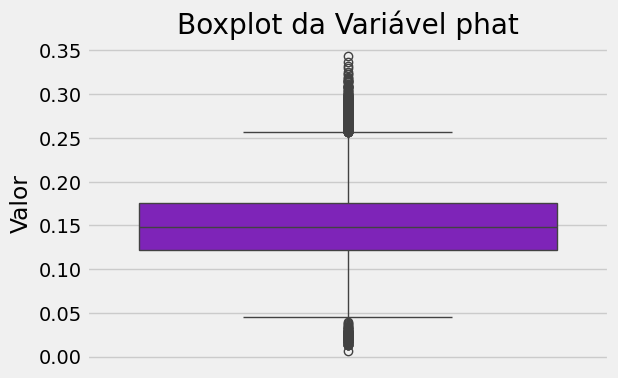

In [179]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=train_smf_glm.phat, color='#830BD1')

plt.title('Boxplot da Variável phat')
plt.ylabel('Valor')

plt.show()

In [180]:
train_smf_glm.phat.describe()

count              36,000.00
mean                    0.15
std                     0.04
min                     0.01
25%                     0.12
50%                     0.15
75%                     0.18
max                     0.34
Name: phat, dtype: float64

- Podemos ver que 0.35 é o valor máximo gerado pela feature phat, média com 0.04 e mediana com 0.15.

### Cutoff

Na Regressão Logística, o **Cutoff** (ou ponto de corte) é um valor limite usado para classificar as probabilidades previstas pelo modelo em categorias discretas, como 0 ou 1 (em problemas de classificação binária). A regressão logística prevê a probabilidade de uma observação pertencer a uma classe (por exemplo, a classe 1), e o cutoff é o valor que define a partir de qual probabilidade a observação será classificada em uma classe ou outra.

**Como funciona o Cutoff na Regressão Logística?**

- Probabilidade prevista: O modelo de regressão logística gera uma probabilidade (entre 0 e 1) para cada observação, indicando a chance de pertencer à classe positiva (por exemplo, classe 1).

- Aplicação do Cutoff: Um valor de cutoff é escolhido (geralmente 0,5, mas pode variar) para transformar essa probabilidade em uma decisão binária:

  - Se a probabilidade for maior ou igual ao cutoff, a observação é classificada como classe 1.

  - Se a probabilidade for menor que o cutoff, a observação é classificada como classe 0.

Por exemplo:

- Se o cutoff for 0,5:

  - Probabilidade ≥ 0,5 → Classe 1

  - Probabilidade < 0,5 → Classe 0

**Impacto do Cutoff:**

- Um cutoff mais baixo (ex.: 0,3) torna o modelo mais "sensível", classificando mais observações como classe 1. Isso pode aumentar a taxa de verdadeiros positivos, mas também pode aumentar os falsos positivos.

- Um cutoff mais alto (ex.: 0,7) torna o modelo mais "conservador", classificando menos observações como classe 1. Isso pode reduzir os falsos positivos, mas também pode aumentar os falsos negativos.

**Escolha do Cutoff**

A escolha do cutoff ideal depende do contexto do problema e dos objetivos do modelo. Algumas abordagens comuns incluem:

- Cutoff padrão (0,5): Usado quando não há preferência específica entre sensibilidade e especificidade.

- Curva ROC e AUC: A Curva ROC (Receiver Operating Characteristic) ajuda a visualizar o desempenho do modelo em diferentes cutoffs. O ponto ideal é aquele que maximiza a sensibilidade e a especificidade.

- Maximização de métricas específicas: Dependendo do problema, pode-se escolher um cutoff que maximize métricas como F1-score, precisão ou sensibilidade.

- Custos associados a erros: Em problemas onde falsos positivos ou falsos negativos têm custos diferentes, o cutoff pode ser ajustado para minimizar o custo total.

### Matriz de Confusão para Cutoff de 0.20

A matriz de confusão é uma ferramenta utilizada em machine learning e estatística para avaliar o desempenho de modelos de classificação. Ela permite visualizar de forma clara os acertos e erros do modelo ao classificar os dados, comparando as previsões feitas pelo modelo com os valores reais (rótulos verdadeiros).

### Estrutura da Matriz de Confusão

Para um problema de classificação binária (duas classes, como "Positivo" e "Negativo"), a matriz de confusão é uma tabela 2x2 com a seguinte estrutura:

![Matriz_de_Confusao](../images/matriz_de_confusao.jpg)

- Verdadeiro Positivo (VP): O modelo previu corretamente a classe positiva.

- Falso Positivo (FP): O modelo previu incorretamente a classe positiva (era negativo).

- Falso Negativo (FN): O modelo previu incorretamente a classe negativa (era positivo).

- Verdadeiro Negativo (VN): O modelo previu corretamente a classe negativa.

### Métricas derivadas da matriz de confusão

A matriz de confusão é usada para calcular métricas de avaliação, como:

- Acurácia: 
$\text{Acurácia} = \frac{VP + VN}{VP + FP + FN + VN}$
​
- Precisão: 
$\text{Precisão} = \frac{VP}{VP + FP}$
​
- Recall (Sensitividade): 
$\text{Recall} = \frac{VP}{VP + FN}$
​
- Especificidade: 
$\text{Especificidade} = \frac{VN}{VN + FP}$

- F1-Score: Média harmônica entre precisão e recall.

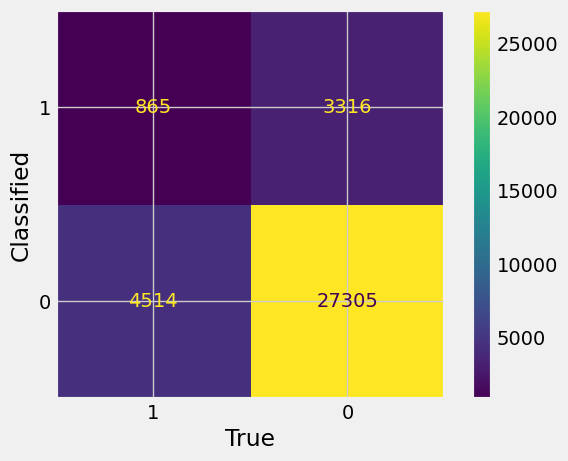

,Sensitividade,Especificidade,Acurácia
0,0.16,0.89,0.78


In [181]:
# Matriz de confusão para cutoff = 0.2
matriz_confusao(observado=train_smf_glm['target_default'],
                predicts=train_smf_glm['phat'], 
                cutoff=0.2)

### Dataframe que contém os vetores mencionados

In [182]:
# Até o momento, foram extraídos 3 vetores: 'sensitividade',
#'especificidade' e 'cutoffs'. Assim, criamos um dataframe que contém
#os vetores mencionados (dataframe 'dados_plotagem')

dados_plotagem = espec_sens(observado = train_smf_glm['target_default'],
                            predicts = train_smf_glm['phat'])


In [183]:
dados_plotagem

,cutoffs,sensitividade,especificidade
0,0.00,1.00,0.00
1,0.01,1.00,0.00
2,0.02,1.00,0.00
3,0.03,1.00,0.02
4,0.04,1.00,0.02
5,0.05,1.00,0.02
6,0.06,1.00,0.02
7,0.07,1.00,0.02
8,0.08,0.99,0.04
9,0.09,0.98,0.07


### O que esses valores indicam sobre o modelo?

- Baixa sensibilidade (0.16) → O modelo está falhando em detectar os positivos, indicando um alto número de falsos negativos.

- Alta especificidade (0.89) → O modelo acerta bem os negativos, errando poucos deles.

- Acurácia razoável (78.25%), mas pode ser enganosa se houver desbalanceamento de classes.

### Gráfico que mostra a variação da especificidade e da sensitividade em função do cutoff

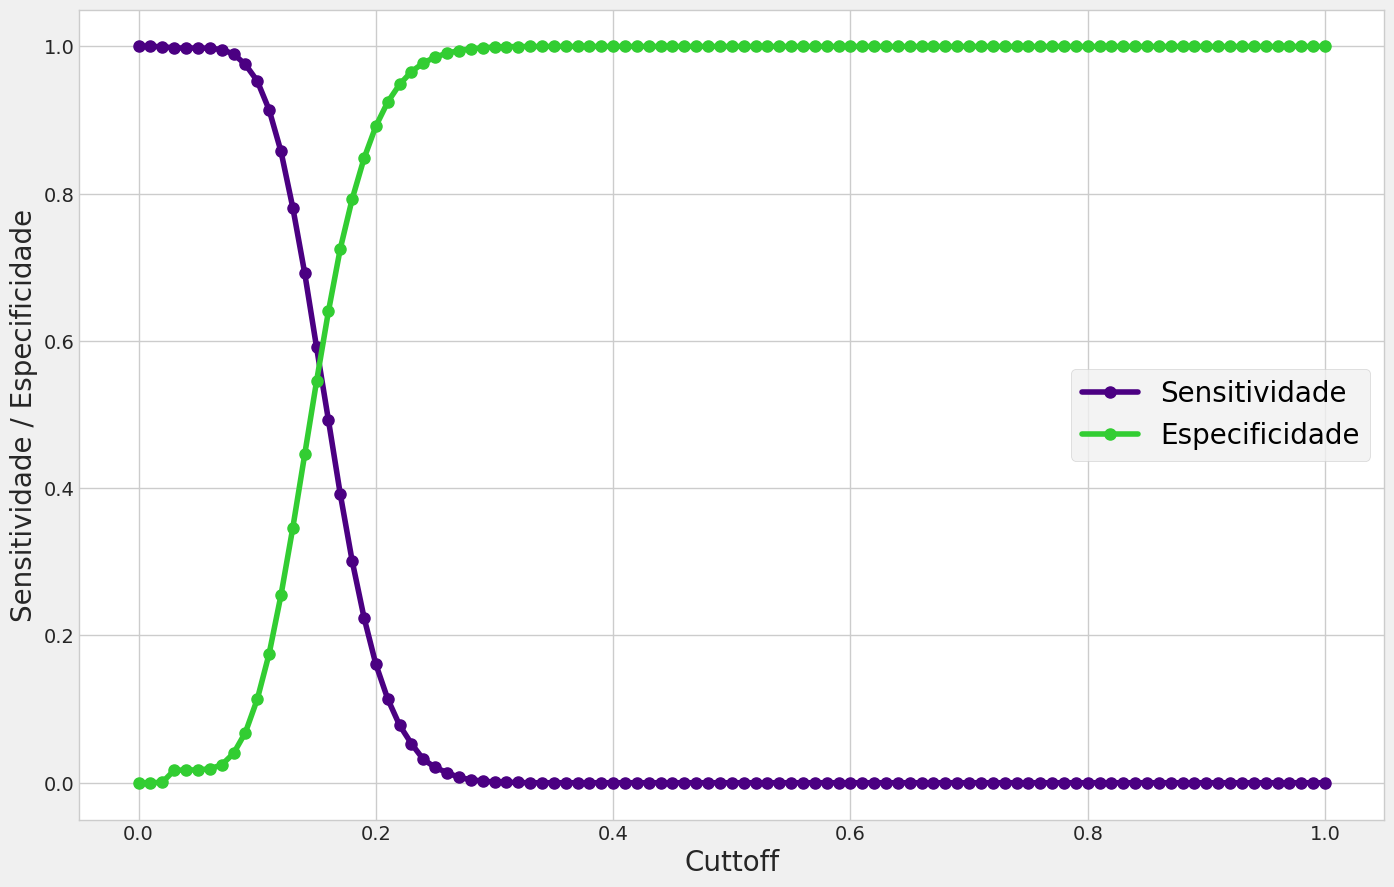

In [184]:
plt.figure(figsize=(15,10))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o',
         color='indigo', markersize=8)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o',
         color='limegreen', markersize=8)
plt.xlabel('Cuttoff', fontsize=20)
plt.ylabel('Sensitividade / Especificidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=20)
plt.show()

### Possíveis soluções

- Alterar o threshold de classificação para aumentar a sensibilidade.
- Usar um modelo diferente, como árvores de decisão, Random Forest ou redes neurais, para melhorar a capacidade preditiva.
- Ajustar pesos na função de custo, dando mais importância para os casos positivos.

### Curva ROC

A **Curva ROC (Receiver Operating Characteristic)** é uma ferramenta gráfica usada para avaliar o desempenho de um modelo de classificação, especialmente em problemas binários (onde a variável dependente tem duas classes, como 0 e 1). Ela é amplamente utilizada para entender a relação entre a **taxa de verdadeiros positivos (Sensibilidade)** e a **taxa de falsos positivos (1 - Especificidade)** em diferentes pontos de corte (thresholds).

Na curva ROC (Receiver Operating Characteristic), o FPR e o TPR são métricas usadas para avaliar a performance de um modelo de classificação binária.

- TPR (True Positive Rate) - Taxa de Verdadeiros Positivos, também chamado de sensibilidade ou recall. Mede a proporção de exemplos positivos corretamente classificados.

- FPR (False Positive Rate) - Taxa de Falsos Positivos. Mede a proporção de exemplos negativos que foram incorretamente classificados como positivos.



### Como esses valores afetam a curva ROC?

- A curva ROC é um gráfico que mostra o TPR no eixo Y e o FPR no eixo X para diferentes limiares de decisão do modelo.

- Um bom modelo tende a ter um TPR alto e um FPR baixo, ou seja, a curva ROC deve estar próxima do canto superior esquerdo.

- O AUC (Área Sob a Curva) mede o desempenho global do modelo, sendo 1 um modelo perfeito e 0.5 equivalente a um modelo aleatório.

- Os thresholds (ou limiares) são os valores de corte (cutoff) usados pelo modelo de classificação para decidir se uma determinada predição pertence à classe positiva ou negativa.

### Objetivos ao Definir o Threshold

- Minimizar o risco de inadimplência

  - Se o banco quer reduzir ao máximo o crédito para clientes de alto risco, o threshold deve ser mais alto (exemplo: 0.7 ou 0.8).

  - Isso significa que o modelo só aprovará clientes com alta confiança de que pagarão o crédito.

  - Consequência: menos falsos positivos (FP, ou seja, menos concessões erradas), mas também pode rejeitar bons clientes.

- Aproveitar mais oportunidades de concessão de crédito

  - Se o banco quer aumentar a base de clientes e oferecer mais crédito, o threshold pode ser mais baixo (exemplo: 0.4 ou 0.5).

  - Isso aprova mais clientes, incluindo aqueles com um certo risco de inadimplência.

  - Consequência: mais falsos positivos (FP, ou seja, mais clientes podem não pagar), mas mais lucro com juros para aqueles que pagam.

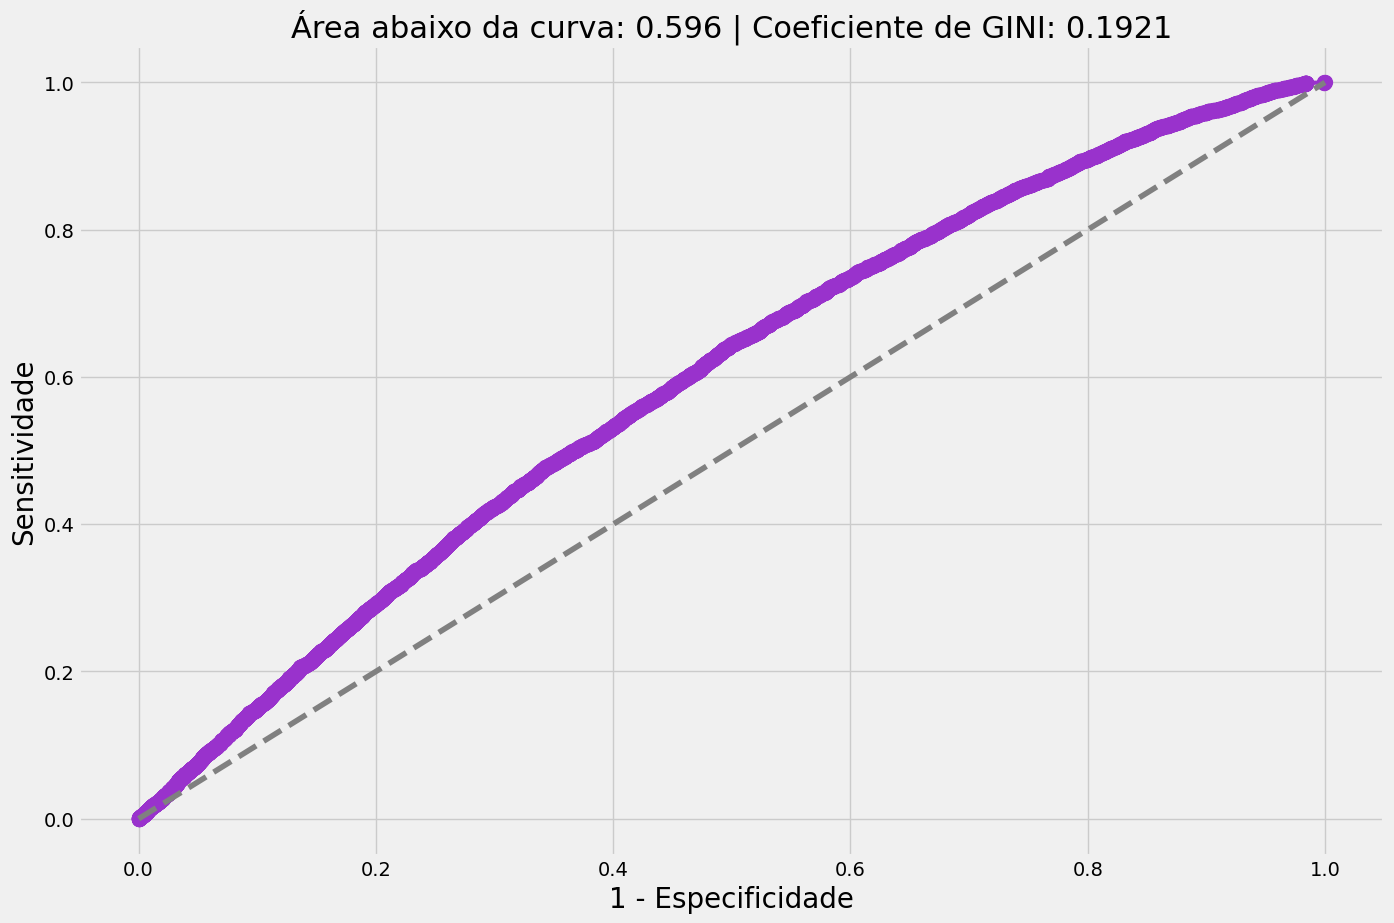

In [185]:
# Construção da curva ROC
fpr, tpr, thresholds =roc_curve(train_smf_glm['target_default'], train_smf_glm['phat'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensitividade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

### Interpretação da Área Sob a Curva ROC (AUC-ROC)

A área sob a curva ROC (AUC-ROC) varia entre 0 e 1:

- 1.0 → Modelo perfeito
- 0.5 → Modelo aleatório (equivalente a um chute)
- < 0.5 → Modelo pior que o aleatório (indicando possível erro na classificação)

No resultado acima de AUC = 0.596, significa que o modelo tem um desempenho ligeiramente melhor do que um modelo aleatório, mas ainda é fraco. Em termos práticos, ele acerta a classificação correta em 59,6% dos casos.

### Interpretação do Coeficiente de Gini

O Coeficiente de Gini é calculado como:

$$G=2×AUC−1$$

Aplicando no case:

$$G=2×0.596−1=0.192$$

O coeficiente de Gini varia entre 0 e 1, onde:

- 1.0 → Modelo perfeito
- 0.0 → Modelo aleatório
- Valores negativos → Modelo pior que o aleatório

Com o resultado do modelo Gini de 0.19, confirma que o modelo tem baixa capacidade preditiva, mas ainda faz um trabalho um pouco melhor do que um chute aleatório.

### Conclusão

O modelo tem baixa capacidade de discriminação entre classes. Como é um modelo de crédito, ele precisa distinguir melhor bons e maus pagadores.

O que pode ser feito?

- Revisar as variáveis preditoras para melhorar a qualidade dos dados.
- Testar modelos de machine learning (árvores de decisão, redes neurais, etc.).
- Realizar feature engineering para extrair melhores padrões dos dados.
- Balancear os dados se houver desbalanceamento entre classes.
- Colocar mais variáveis independentes na base.


### Pipeline para Machine Learning

Um pipeline de machine learning é uma sequência automatizada e organizada de etapas que transforma dados brutos em um modelo de machine learning pronto para uso. Ele integra várias tarefas, como pré-processamento de dados, seleção de características, treinamento do modelo, avaliação e implantação, em um fluxo de trabalho coeso. O objetivo é simplificar, padronizar e acelerar o processo de desenvolvimento de modelos, garantindo consistência e reprodutibilidade.

Implementaremos primeiramente aqui no Pipeline o StandardScaler().

O StandardScaler() é uma ferramenta do scikit-learn, usada para padronizar as características (features) de um conjunto de dados. A padronização é um processo comum em pré-processamento de dados, especialmente em algoritmos que são sensíveis à escala das features, como SVM, regressão linear, e redes neurais.

O que o StandardScaler() faz?

Ele transforma os dados de forma que a distribuição resultante tenha:

- Média zero: A média dos valores de cada feature é ajustada para 0.

- Variância unitária: A variância dos valores de cada feature é ajustada para 1.

Isso é feito subtraindo a média dos valores e dividindo pelo desvio padrão. Matematicamente, para cada valor 
$x$ de uma feature:

$$ z = \frac{x - \mu}{\sigma} $$

Onde:

$μ$ é a média da feature.

$σ$ é o desvio padrão da feature.

Quando usar o StandardScaler()?

- Quando os algoritmos de machine learning que você está usando são sensíveis à escala dos dados.

- Quando as features têm unidades diferentes (por exemplo, metros e quilogramas).

- Quando você deseja que todas as features contribuam igualmente para o modelo, evitando que features com valores maiores dominem o processo de aprendizado.


In [186]:
numerical_pipeline = Pipeline(
    steps=[
        ('std_scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', numerical_pipeline, numerical_features)
    ], remainder="passthrough"
)

In [187]:
X_train_prepared = preprocessor.fit_transform(X_train, y_train)
X_train_prepared.shape

(36000, 17)

## Criação dos Modelos de ML

Vamos avaliar diferentes modelos de classificação em um conjunto de dados previamente preparado. Ele utiliza a métrica **ROC AUC** para comparar o desempenho dos modelos e emprega validação cruzada estratificada para garantir resultados mais confiáveis.

## Modelos Utilizados
Os seguintes modelos de classificação são avaliados:
- **Logistic Regression**
- **Random Forest**
- **XGBoost**
- **LGBM**
- **CatBoost**

## Metodologia
1. Cada modelo é instanciado e treinado com os dados de treino (`X_train_prepared`, `y_train`).
2. O tempo de treinamento de cada modelo é registrado.
3. As previsões são feitas tanto no conjunto de treino (`X_train_prepared`) quanto no conjunto de teste (`X_test`).
4. O desempenho é avaliado utilizando a métrica **ROC AUC**:
   - **Score no conjunto de treino**
   - **Média da validação cruzada** (`cross_val_score` com 5 folds estratificados)
   - **Desvio padrão da validação cruzada**
5. Os resultados são armazenados em dicionários para análise posterior:
   - `models_train_scores`: armazena o ROC AUC do treino.
   - `models_val_scores`: armazena a média do ROC AUC na validação cruzada.
6. Os resultados de cada modelo são impressos no console, incluindo o tempo de treinamento.


Logistic Regression results: 
--------------------------------------------------
Training score: 0.5685968057418902
Average validation score: 0.5945336072957572
Standard deviation: 0.005911124905131469
Training time: 0.0321 seconds

Random Forest results: 
--------------------------------------------------
Training score: 0.9999070459193158
Average validation score: 0.5678117301786962
Standard deviation: 0.010175649351484383
Training time: 6.0257 seconds

XGBoost results: 
--------------------------------------------------
Training score: 0.8098454936887122
Average validation score: 0.5601850051199813
Standard deviation: 0.007298714884885635
Training time: 0.20292 seconds

[LightGBM] [Info] Number of positive: 5379, number of negative: 30621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1227
[LightGBM] [Info] Number of data points in the train

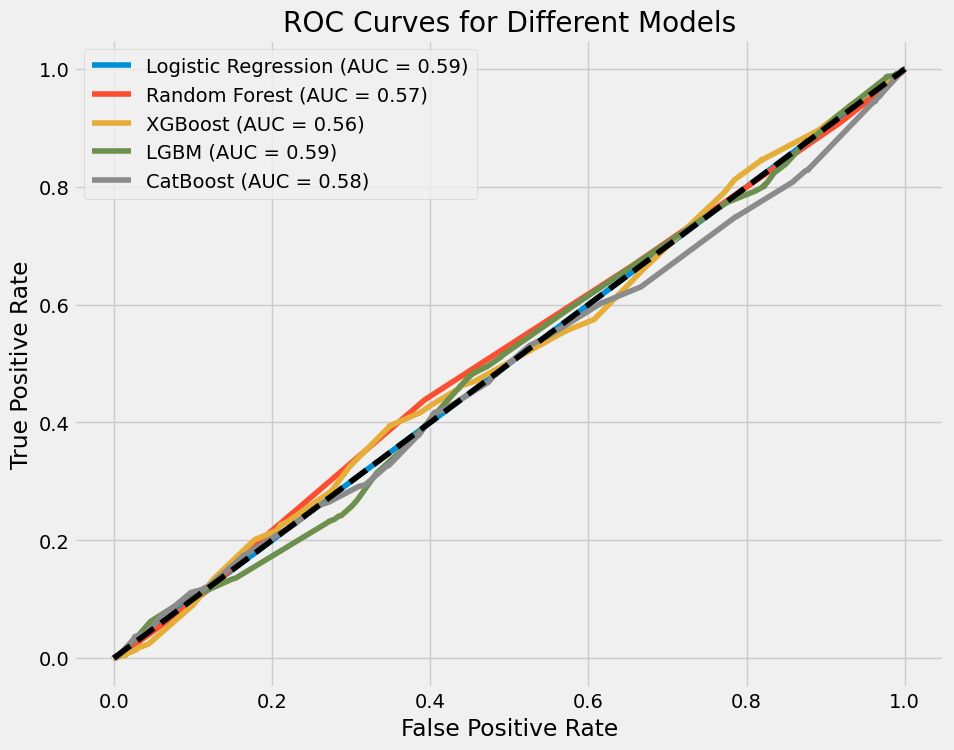

In [188]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Calcule a razão entre as classes
scale_pos_weight = sum(y == 0) / sum(y == 1)

models = {
    'Logistic Regression': LogisticRegression(class_weight="balanced", random_state=42),
    'Random Forest': RandomForestClassifier(class_weight="balanced", random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric="logloss"),
    'LGBM': lgb.LGBMClassifier(is_unbalance=True),
    'CatBoost': CatBoostClassifier(class_weights=[1, scale_pos_weight])
}



model_list = []
models_val_scores = {}
models_train_scores = {}

n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

plt.figure(figsize=(10, 8))

for name, model in models.items():
    start_time = time.time()
    
    model.fit(X_train_prepared, y_train) 
    
    end_time = time.time()
    training_time = end_time - start_time
    
    y_train_pred = model.predict(X_train_prepared)
    y_test_pred = model.predict(X_test)
    
    train_score = roc_auc_score(y_train, y_train_pred)
    val_scores = cross_val_score(model, X_train_prepared, y_train, scoring='roc_auc', cv=stratified_kfold)
    avg_val_score = val_scores.mean()
    val_score_std = val_scores.std()
    
    models_val_scores[name] = avg_val_score
    models_train_scores[name] = train_score
    model_list.append(name)
    
    # Cálculo da curva ROC
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {avg_val_score:.2f})')
    
    print(f'{name} results: ')
    print('-' * 50)
    print(f'Training score: {train_score}')
    print(f'Average validation score: {avg_val_score}')
    print(f'Standard deviation: {val_score_std}')
    print(f'Training time: {round(training_time, 5)} seconds')
    print()

plt.plot([0, 1], [0, 1], 'k--')  # Linha de referência
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()


## Resultados dos Modelos

### 1. **Logistic Regression**
- **Training score:** 0.5686
- **Average validation score:** 0.5945
- **Standard deviation:** 0.0059
- **Training time:** 0.0310 segundos

### 2. **Random Forest**
- **Training score:** 0.9999
- **Average validation score:** 0.5678
- **Standard deviation:** 0.0102
- **Training time:** 5.9086 segundos

### 3. **XGBoost**
- **Training score:** 0.8098
- **Average validation score:** 0.5602
- **Standard deviation:** 0.0073
- **Training time:** 0.2992 segundos

### 4. **LGBM**
- **Training score:** 0.7105
- **Average validation score:** 0.5864
- **Standard deviation:** 0.0041
- **Training time:** 0.14418 segundos

### 5. **CatBoost**
- **Training score:** 0.7579
- **Average validation score:** 0.5786
- **Standard deviation:** 0.0061
- **Training time:** 9.6981 segundos

## Análise dos Resultados

### Observações Gerais
- **Logistic Regression** apresentou o melhor desempenho de validação, com uma boa média de **(0.5945)**. O modelo teve uma boa relação entre os scores de treinamento e validação, sem sinais de overfitting.
  
- **Random Forest** teve um **overfitting severo**, com um score de treino quase perfeito **(0.9999)** e um desempenho significativamente inferior na validação **(0.5678)**. Isso sugere que o modelo está memorizando os dados de treino e não generalizando bem para dados não vistos.
  
- **XGBoost** teve um bom desempenho de treino **(0.8098)**, mas a validação é ligeiramente pior **(0.5602)**. Esse modelo teve um tempo de treinamento bem mais rápido que o Random Forest e o CatBoost.

- **LGBM** teve um desempenho razoável de **(0.7105)**, e um score de validação de **(0.5864)**. Seu tempo de treinamento foi significativamente pequeno, **(0.14)**, assim como foi com XGBoost.

- **CatBoost** teve também um desempenho razoável de **(0.7579)**, com um score de validação de **(0.5786)**. Embora tenha um bom desempenho comparado aos outros, o tempo de treinamento é significativamente mais alto **(9.6981 segundos)**.

## Melhorias para Aumentar o Desempenho

***Como não tivemos resultados significantes para a curva ROC entre os modelos, acreditamos que o ideal ainda seja obter mais variáveis significativas para a base dos dados, mas vamos por enquanto trabalhar no aprimoramento desses modelos.***

- **Logistic Regression** teve o melhor desempenho de validação, mas pode ser ajustado para melhorar a curva ROC.
- **Random Forest** sofreu com overfitting, necessitando ajustes de hiperparâmetros.
- **XGBoost**, **LGBM** e **CatBoost** podem ser melhorados com ajuste fino de hiperparâmetros e balanceamento de dados.
  
Combinar modelos com **ensemble learning** pode melhorar a performance geral.

